# Ideas and thoughts

I refer to "galactic years" as just years using their ordinal value (i.e. 1st, 2nd, … 26th), since there is a clear constant increment in the raw data.

## Part 1 of the task
enrich data using open source info? - later, after getting some interim results from basic algorithms  
Match countries with galaxies using that information? - same  
Add Human development index feature using UN methodology - after basic algos  
Distribution of index over years for each country - visualize  

### Step 0. Preprocessing choices
#### Categorical data encoding
We have 2 categorical features "galactic year" and "galaxy" of cardinalities 26 and 181 respectively  
Options for year encoding:  
1) Some approach from time-series analysis. Could be just ordinal encoding (1, 2, 3 ... 26)  

Consider:
There is a weird peak of average y in the last 4 years 

Options for "galaxy" encoding:  
1) One-hot encoding — costly in terms of additional features  
2) Mean encoding — reflects relationship between galaxy and it's average index, but prone to overfitting (careful)  

WE may just omit these features altogether! See motivation further down

#### Dealing with missing values (CRITICAL)
Options:  
1) Blanket replace NaN with zeroes - simplest,  xgboost score ~0.028-0.03  
2) Blanket replace NaN with feature mean - also simple  
3) Copy value from closest neighbour in feature space  
4) Using some EM algorithm - advanced  
5) Delete features with more than some amount of missing values  

Consider:  
Could the absence of data for a particular galaxy be another piece of information itself? In context of the problem, better developed galaxies should have more data collection capabilities than less developed ones.


### Step 1. Data splitting and CV strategy

Use sklearn's TimeSeriesSplit? 

It may be wise to transform the target to fit a normal distribution if using a linear regressor. Use QuantileTransformer.  
Initially, I do not consider the name of the galaxy or the galactic year in training

### Step 2. Model selection and testing

#### If omitting galactic year and galaxy name and replacing NaNs with zeros

best params for SGDregressor:
```python
{'alpha': 0.01,
 'epsilon': 0.3,
 'learning_rate': 'adaptive',
 'loss': 'huber',
 'penalty': 'l2'}
```

best params for XGBoost:
```python
{'regressor__learning_rate': 0.1,
 'regressor__max_depth': 4,
 'regressor__n_estimators': 400}
```

### Data exploration insights
* Is there any cyclicity of average y of all galaxies between galactic years? — No, at least for cycles with periods of less than 26 years. Based on a ```data.groupby(['galactic year'])['y'].mean()``` graph. Also on the same graph there exists an anomalous peak around last 4 years. -> something to look into
* y has a distribution close to an exponential -> consider using a transformer for linear models
* last 5 entries are completely empty -> consider using the most likely y pred for them based on train data. This also leads me to consider analyzing the sparsity of test data  

!! Surely the index y has to be calculated regardless of the galaxy or the galactic year? 

## Part 2 of the task
Every galaxy has a limited potential for improvement in the index described by potential:  
$$P_i = -\ln (y_i + 0.01) + 3,$$
where $y_i$ is the development index of a galaxy $i$.  

Likely index increase $\Delta y_i$ dependent on potential for improvement $P$ and on extra energy availability $E_i$ is described by the following function:

$$\Delta y_i = \dfrac {E_i P_i^2}{1000} = \dfrac{E_i(-\ln (y_i + 0.01) + 3)^2}{1000}$$

The task is to maximize $f(E) = \displaystyle \sum_{i = 0}^{889} \Delta y_i (E_i)$ given the constraints:  
1) $E = \displaystyle \sum_{i=0}^{889}E_i = 50000$ units available for allocation (across 890 objects --)  
2) $0 \leq E_i \leq 100 $ for all $i$  
3) all galaxies with Existence Expectancy Index $EEI_i < 0.7$ should be allocated at least 10% of the total energy available (i.e. 5000 units)

### Solution

*Note: I refer to each row of the test as a "point". Each such "point" has an index $i$, which is just it's index in the test.csv  
1 unit of energy = 1 zillion DSML in the original wording of the problem*

**TL;DR  
Allocate 100 units each to the 50 largest by $\alpha_i$ points that satisfy $EEI_i<0.7$. Then allocate 100 units each to the 450 largest by $\alpha_i$ out of the $890-50=840$ remaining points**


Let's denote $\alpha_i = \dfrac{P_i^2}{1000}$. Then the likely index increase can be written as $\Delta y_i = \alpha_i E_i$. Function $f(E)$ to be maximized therefore transforms to: 

$$f(E) = \displaystyle \sum_{i=0}^{889}\alpha_i E_i$$

Since we consider each $y_i$ to be a known quantity (assuming we have predicted $y$ with a reasonable degree of certainty), then $\alpha_i$ becomes another series of known coefficients.  

Consider $f(E)$ to be a function of 890 linear arguments $E_i$. The direction of the fastest ascent of this function is given by the gradient: $$\nabla f(E) = \begin{align}
     \begin{pmatrix}
           \alpha_{1} \\
           \alpha_{2} \\
           \vdots \\
           \alpha_{890}
         \end{pmatrix}
  \end{align}$$
Let's sort these values in the descending order, so that 
$$\alpha = \{\alpha_{(1)} \geq \alpha_{(2)} \geq \ldots \geq \alpha_{(k)} \geq \ldots \geq \alpha_{(890)}\}$$

It is clear that in the presence of only the constraints one and two the most optimum solution would have been to simply allocate 100 units of energy each to 500 points that are the largest by $\alpha$.

Indeed, having only a limited amount of total energy and in order to maximize the function $f(E)$, it would have been optimal to allocate *all of the total energy* (50000 units) to the point with $\alpha_{(1)}$, i.e. with the largest gradient element. However, since the allocation for each point $i$ is limited, the next best thing is to designate as much energy as possible to the point with $\alpha_{(2)}$. This logic continues until we reach point $i=500$ and run out of energy to allocate. 

Let's satisfy the third constraint while maintaining an optimum solution. We know the indices of points with $EEI_i < 0.7$: $$k = \{i: EEI_i <0.7 \} \text{, where k is a set of indices}$$ and therefore know the $\alpha_k$ — a subset of set $\alpha$. Now, let's allocate to these points $k$ as little energy as possible in order to satisfy all three constraints *and* maximize the gain on the function. It is evident, that the first 50 points in this subset by order of $\alpha_k$ have to be selected to be given 100 units of energy. Then, we can use the approach outlined in the previous paragraph, but now we should find the optimal solution in a smaller space of $890-50=840$ leftover points and use only 45000 units of energy to spend. This equates to selecting the 450 largest points of this space by $\alpha$ value and designating 100 units to each of them. 

### Type = Linear programming problem with constraints?

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

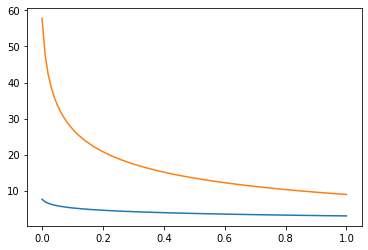

In [8]:
xs = np.linspace(0, 1, 100)
ys = (-np.log(xs + 0.01) + 3)
plt.plot(xs, ys, label='a')
plt.plot(xs, ys**2, label='b')